In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import get_optimizing_joints, CalculateMultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

In [2]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.29], 0.1, 0.24, 20, 40))

ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.05, -0.28], step_height=0.05, step_width=0.1, n_points=50))

left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.1, -0.28], step_height=0.05, step_width=0.1, n_points=50))

right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.0, -0.28], step_height=0.05, step_width=0.1, n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, -0.075, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0.075, 50))

In [3]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0)

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

In [4]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass()
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

In [5]:
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(left_shift_step, 1)
reward_manager.add_trajectory(right_shift_step, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)


reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)


reward_manager.add_trajectory_aggregator([0,1,2], 'mean')
reward_manager.add_trajectory_aggregator([3,4,5], 'mean')

#reward_manager.close_trajectories()

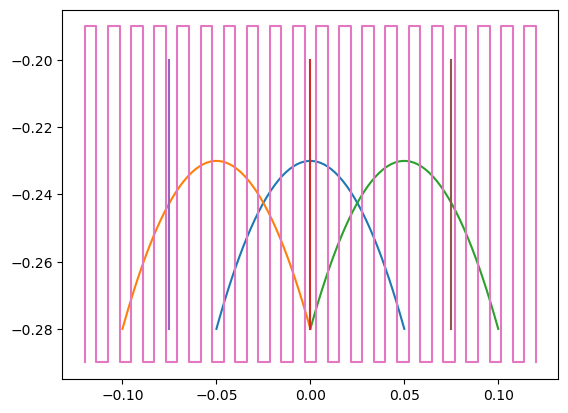

In [6]:

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [7]:

population_size = 32
n_generations = 200
for i in range(2,3):
    # the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
    graph, constrain_dict = all_graphs[i]
    optimizing_joints = get_optimizing_joints(graph, constrain_dict)
    # create the problem for the current optimization
    problem = CalculateMultiCriteriaProblem(graph,builder, optimizing_joints, reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

    saver = ProblemSaver(problem, f"prikol_1\\topology_{i}", True)
    saver.save_nonmutable()
    algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm, saver)

    res = optimizer.run(
        True, **{
            "seed": 4,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })
    
    path = saver.path
    F = res.F
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    weights = np.array([0.4, 0.6])
    
    decomp = ASF()
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[i]
    problem.mutate_JP_by_xopt(best_x)
    draw_joint_point(problem.graph)
    plt.savefig(os.path.join(path,f'weights_04_06'))

ValueError: All points should be reachable to calculate a reward [0.00029822]

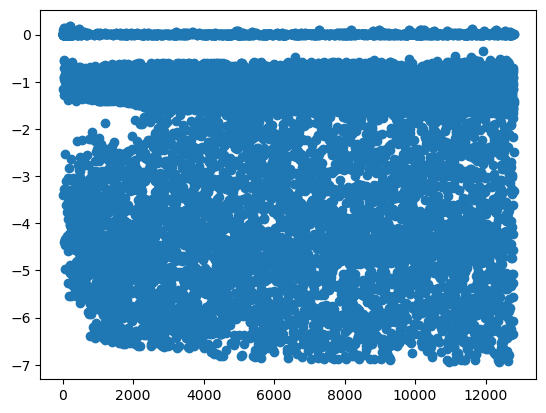

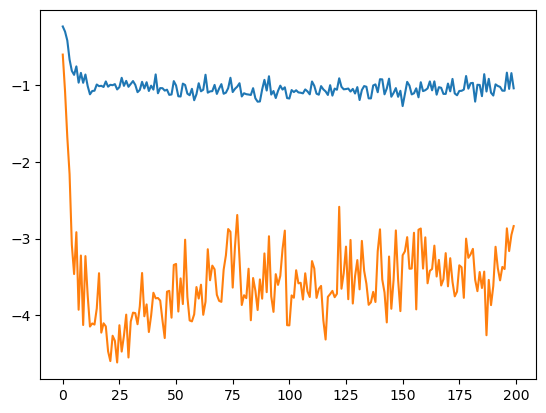

In [ ]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

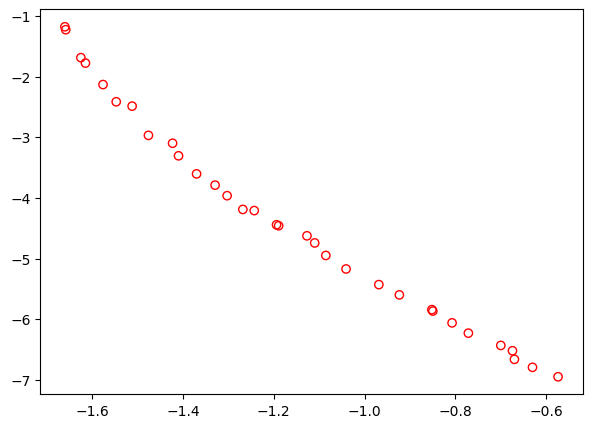

In [ ]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:,0],F[:,1],  facecolors='none', edgecolors='r')